# 🚀 Winner Model: Transfer learning (VGG16):

We are building a new model base on VGG16 to predict animals.

## 📦 1. Setup and Imports

In [14]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from google.colab import drive

## 📁 2. Mount Drive and Extract Data

In [16]:
def mount_and_extract(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(extract_to))
        print(f"✅ Extracted: {os.path.basename(zip_path)}")
    else:
        print(f"📁 Already extracted: {extract_to}")

# Mount Drive and extract
drive.mount('/content/drive')

mount_and_extract("/content/drive/MyDrive/IronHack/animals10.zip", "/content/animals10/raw-img")
mount_and_extract("/content/drive/MyDrive/IronHack/holdout.zip", "/content/animals10/holdout/raw-img")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted: animals10.zip
📁 Already extracted: /content/animals10/holdout/raw-img


## 🧼 3. Preprocessing with ImageDataGenerator

In [17]:
def create_generators(base_path, img_size=(128, 128), batch_size=32, seed=42):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        validation_split=0.2
    )

    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = train_datagen.flow_from_directory(
        base_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=seed
    )

    val_gen = val_datagen.flow_from_directory(
        base_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=seed
    )

    return train_gen, val_gen

train_generator, val_generator = create_generators(animals_dataset_path)

Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.


## 🖼️ 4. Preview Sample Images

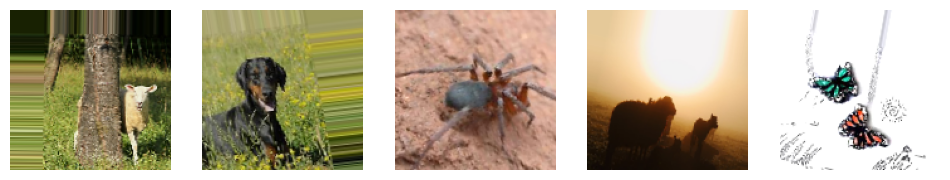

In [18]:
def preview_images(generator):
    imgs, _ = next(generator)
    plt.figure(figsize=(12, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

preview_images(train_gen)

## 🏗️ 5. Model architecture:
- Load VGG16 model from keras.
- Freeze the weights on all the layers but unfreeze the last 10 layers to allow fine-tuning.
- Add 3 Dense layers to extract high-level features into the final predictions, plus the softmax classification dense layer at the end.
- Adds L2 regularization (penalizes large weights to prevent overfitting).
Dropout 0.4.(Drops 40% of neurons randomly during training.)

In [19]:
def build_vgg16_transfer_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(512, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(256, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(10, activation='softmax'))
    return model

model = build_vgg16_transfer_model()

## 🚂 6. Train the Model

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=5e-5),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 151s 242ms/step - accuracy: 0.8971 - loss: 0.8987 - val_accuracy: 0.8819 - val_loss: 0.9359 - learning_rate: 5.0000e-05
Epoch 2/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 138s 233ms/step - accuracy: 0.9030 - loss: 0.8450 - val_accuracy: 0.8787 - val_loss: 0.9093 - learning_rate: 5.0000e-05
Epoch 3/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 136s 231ms/step - accuracy: 0.9096 - loss: 0.8024 - val_accuracy: 0.9076 - val_loss: 0.7789 - learning_rate: 5.0000e-05
Epoch 4/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 139s 235ms/step - accuracy: 0.9200 - loss: 0.7371 - val_accuracy: 0.9102 - val_loss: 0.7732 - learning_rate: 5.0000e-05
Epoch 5/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 136s 231ms/step - accuracy: 0.9143 - loss: 0.7298 - val_accuracy: 0.8983 - val_loss: 0.7998 - learning_rate: 5.0000e-05
Epoch 6/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 135s 229ms/step - accuracy: 0.9253 - loss: 0.6728 - val_accuracy: 0.8845 - val_loss: 0.8369 - learning_rate: 5.0000e-05
Epoch 7/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 

## 📊 7. Evaluate Performance

In [23]:
# Evaluate on validation set
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Final training metrics
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9129 - loss: 0.7646
Validation Accuracy: 91.02%
Validation Loss: 0.7732
Training Accuracy: 92.75%
Training Loss: 0.5966


## 📈8. Plot Accuracy and Loss

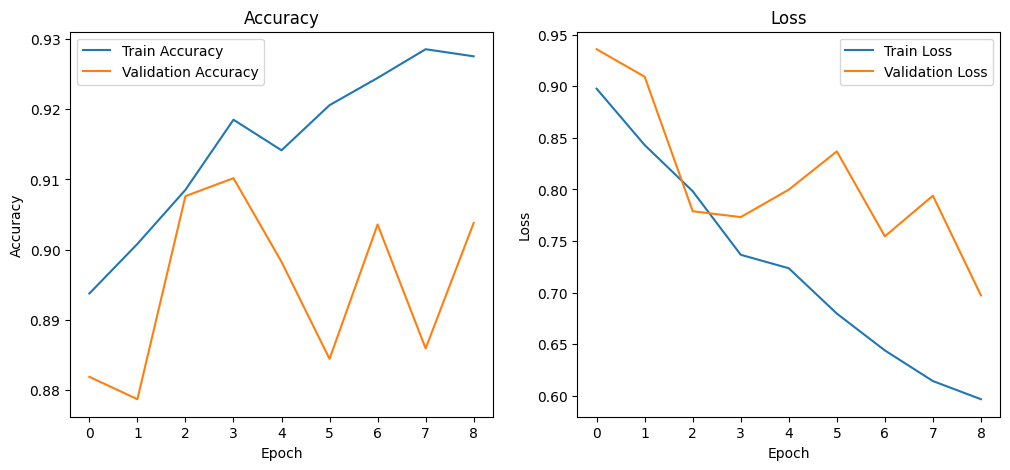

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 🧪9. Predict on Validation Set

In [26]:
from sklearn.metrics import classification_report

# Predictions
y_true, y_pred = [], []
class_labels = list(train_generator.class_indices.keys())

for images, labels in val_generator:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_generator.samples:
        break

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


📊 Classification Report:

              precision    recall  f1-score   support

   butterfly       0.91      0.96      0.94       380
         cat       0.96      0.84      0.89       300
     chicken       0.81      0.97      0.88       557
         cow       0.89      0.87      0.88       336
         dog       0.94      0.89      0.91       875
    elephant       0.88      0.95      0.91       260
       horse       0.92      0.92      0.92       472
       sheep       0.87      0.84      0.86       327
      spider       0.96      0.95      0.95       867
    squirrel       0.95      0.82      0.88       335

    accuracy                           0.91      4709
   macro avg       0.91      0.90      0.90      4709
weighted avg       0.91      0.91      0.91      4709



## 📈10. Confusion Matrix

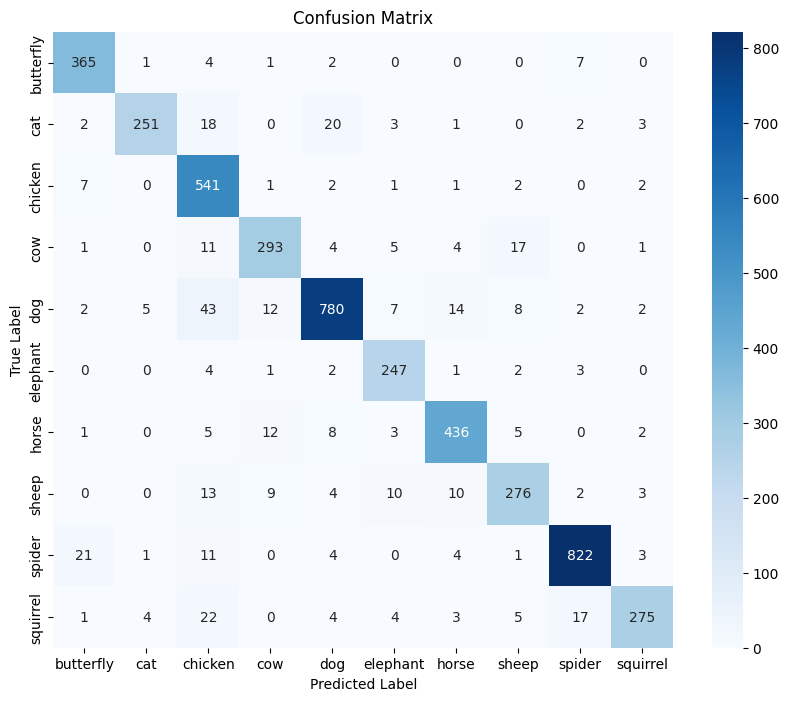

In [27]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 🔍 11. Predict on Holdout Set

In [28]:
class_labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
correct = 0
misclassified = []
total = 0

holdout_dataset_path = "/content/animals10/holdout/raw-img"

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)
    if not os.path.isdir(class_folder):
        continue
    for file in os.listdir(class_folder):
        if not file.lower().endswith(('jpg', 'jpeg', 'png')):
            continue

        img_path = os.path.join(class_folder, file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = np.expand_dims(image.img_to_array(img), axis=0) / 255.
        pred = model.predict(img_array, verbose=0)
        pred_label = class_labels[np.argmax(pred)]
        total += 1
        if pred_label == class_name:
            correct += 1
        else:
            misclassified.append((img_path, class_name, pred_label))

acc = (correct / total) * 100 if total > 0 else 0
print(f"\n✅ Accuracy on Holdout Set: {acc:.2f}%")
print(f"🔢 Correct Predictions: {correct} / {total}")


✅ Accuracy on Holdout Set: 95.15%
🔢 Correct Predictions: 2238 / 2352


## 🖼️ 12. Display Misclassified Holdout Samples


❌ Showing 8 Misclassified Images:


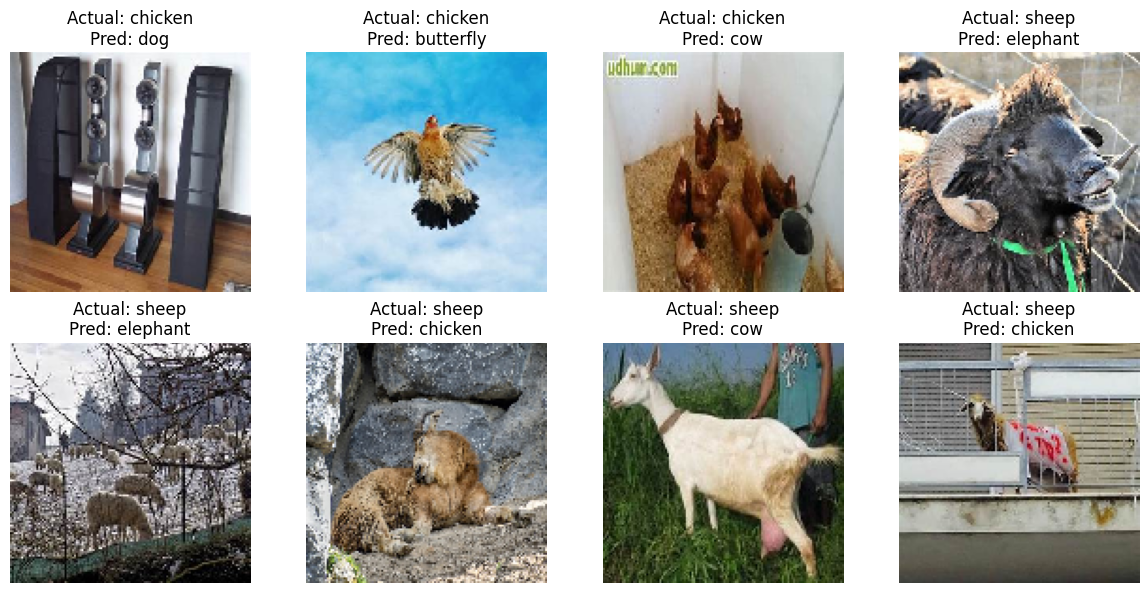

In [30]:
if misclassified:
    print(f"\n❌ Showing {min(8, len(misclassified))} Misclassified Images:")
    plt.figure(figsize=(12, 6))
    for i, (path, true, pred) in enumerate(misclassified[:8]):
        img = image.load_img(path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {true}\nPred: {pred}")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassifications found!")

In [32]:
from google.colab import files
files.download("/content/vgg16_animal_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>